## Estimating cell cycle phases

In this vignette we will demonstrate how to identify cell cycle phases using single-cell RNA-Seq data

In [1]:
%load_ext autotime

import scarf
scarf.__version__

'0.17.1'

time: 1.36 s (started: 2021-08-22 12:46:04 +02:00)


---
### 1) Fetch pre-analyzed data

Here we use the data from [Bastidas-Ponce et al., 2019 Development](https://journals.biologists.com/dev/article/146/12/dev173849/19483/) for E15.5 stage of differentiation of endocrine cells from a pool of endocrine progenitors-precursors. 

We have stored this data on Scarf's online repository for quick access. We processed the data to identify the highly variable genes (top 2000) and create a neighbourhood graph of cells. A UMAP embedding was calculated for the cells. 

In [2]:
scarf.fetch_dataset(
    'bastidas-ponce_4K_pancreas-d15_rnaseq',
    save_path='./scarf_datasets',
    as_zarr=True,
)

INFO: Download finished! File saved here: C:\Users\parashar\Desktop\scarf_vignettes\scarf_datasets\bastidas-ponce_4K_pancreas-d15_rnaseq\data.zarr.tar.gz
INFO: Extracting Zarr file for bastidas-ponce_4K_pancreas-d15_rnaseq
time: 17.7 s (started: 2021-08-22 12:46:06 +02:00)


In [3]:
ds = scarf.DataStore(f"scarf_datasets/bastidas-ponce_4K_pancreas-d15_rnaseq/data.zarr",
                     nthreads=4, default_assay='RNA')

time: 31 ms (started: 2021-08-22 12:46:23 +02:00)


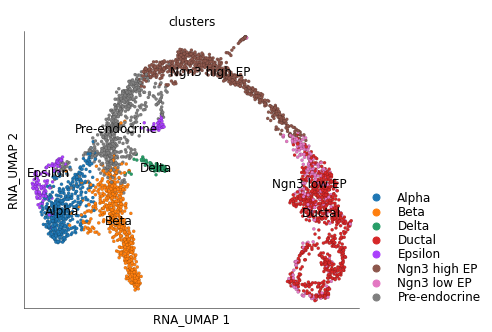

time: 937 ms (started: 2021-08-22 12:46:23 +02:00)


In [4]:
ds.plot_layout(layout_key='RNA_UMAP', color_by='clusters')

---
### 2) Run cell cycle scoring

The cell cycle scoring function in Scarf is highly inspired by the [equivalent function](https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.score_genes_cell_cycle.html) in Scanpy. The cell cycle phase of each individual cell is identified following steps below:
- A list of S and G2M phase is provided to the function (Scarf already has a generic list of genes that works both for human and mouse data)
- Average expression of all the genes (separately for S and G2M lists) in across `cell_key` cells is calculated
- The log average expression is divided in `n_bins` bins
- A control set of genes is identified by sampling genes from same expression bins where phase's genes are
present.
- The average expression of phase genes (Ep) and control genes (Ec) is calculated per cell.
- A phase score is calculated as: Ep-Ec
Cell cycle phase is assigned to each cell based on following rule set:
- G1 phase: S score < -1 > G2M sore
- S phase: S score > G2M score
- G2M phase: G2M score > S score

In [5]:
ds.run_cell_cycle_scoring()

time: 1.09 s (started: 2021-08-22 12:46:24 +02:00)


---
### 3) Visualize cell cycle phases

By default the cell cycle phase information in stored under cell attribute table under column/key `RNA_cell_cycle_phase`.
We can color the UMAP plot based on these values.

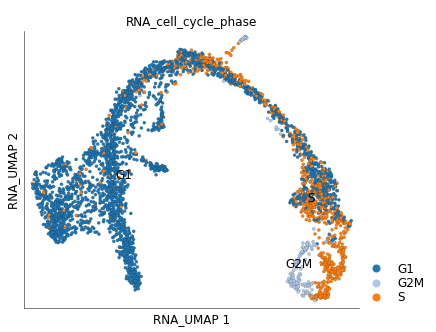

time: 187 ms (started: 2021-08-22 12:46:25 +02:00)


In [6]:
ds.plot_layout(
    layout_key='RNA_UMAP',
    color_by='RNA_cell_cycle_phase',
    cmap='tab20',
)

We can clearly see that cycling group of cells in the 'ductal' group. You can provide your own custom color mappings like below:

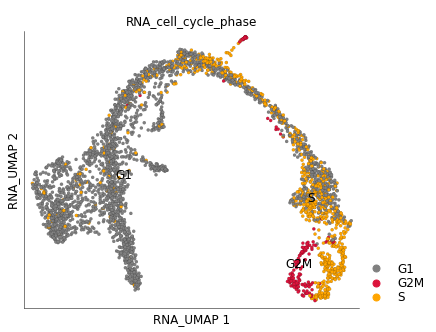

time: 188 ms (started: 2021-08-22 12:46:26 +02:00)


In [7]:
color_key = {
    'G1': 'grey',
    'S': 'orange',
    'G2M': 'crimson',
}
ds.plot_layout(
    layout_key='RNA_UMAP',
    color_by='RNA_cell_cycle_phase',
    color_key=color_key,
)

---
### 4) Visualize phase specific scores

The individual and S and G2M scores for each cell are stored under columns `RNA_S_score` and `RNA_G2M_score`. We can visualize the distribution of these scores on the UMAP plots

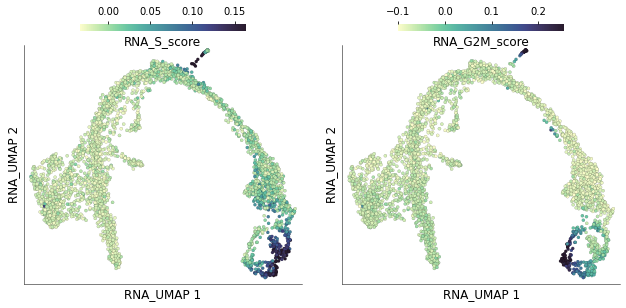

time: 781 ms (started: 2021-08-22 12:46:26 +02:00)


In [8]:
ds.plot_layout(
    layout_key='RNA_UMAP',
    color_by=['RNA_S_score', 'RNA_G2M_score'],
    width=4.5, height=4.5,
)

---
### 5) Compare with scores calculated using Scanpy

The dataset we downloaded, already had cell cycle scores calculated using Scanpy. For example, the S phase scores are stored under the column `S_score`. We can plot these scores on the UMAP.

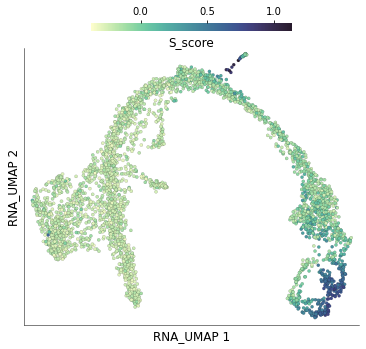

time: 453 ms (started: 2021-08-22 12:46:27 +02:00)


In [9]:
ds.plot_layout(
    layout_key='RNA_UMAP',
    color_by='S_score',
)

Unsurprisingly, these scores look very similar to those obtained through Scarf. Let's quantify the concordance below

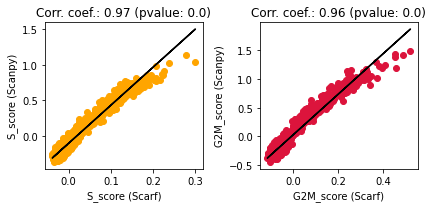

time: 204 ms (started: 2021-08-22 12:46:27 +02:00)


In [10]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

fig, axis  = plt.subplots(1, 2, figsize=(6,3))
for n,i in enumerate(['S_score', 'G2M_score']):
    x = ds.cells.fetch(f"RNA_{i}")
    y = ds.cells.fetch(i)
    res = linregress(x, y)
    
    ax = axis[n]
    ax.scatter(x, y, color=color_key[i.split('_')[0]])
    ax.plot(x, res.intercept + res.slope*x, label='fitted line', c='k')
    ax.set_xlabel(f"{i} (Scarf)")
    ax.set_ylabel(f"{i} (Scanpy)")
    ax.set_title(f"Corr. coef.: {round(res.rvalue, 2)} (pvalue: {res.pvalue})")

plt.tight_layout()
plt.show()

High correlation coefficients indicate a large degree of concordance between the scores obtained using Scanpy and Scarf

---
That is all for this vignette.